In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pymc3 import  *
import theano
import pandas as pd
from statsmodels.formula.api import glm as glm_sm
import statsmodels.api as sm
from pandas.plotting import scatter_matrix

# Linear Regression
Lets generate some data with known slope and intercept and fit a simple linear GLM.

In [2]:
size = 50
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
y = true_intercept + x*true_slope + np.random.normal(scale=.5, size=size)
data = {'x': x, 'y': y}

The glm.linear_component() function can be used to generate the output variable y_est and coefficients of the specified linear model.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, x, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1323.20draws/s]
The acceptance probability does not match the target. It is 0.902734119488141, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8835534297667511, but should be close to 0.8. Try to increase the number of tuning steps.


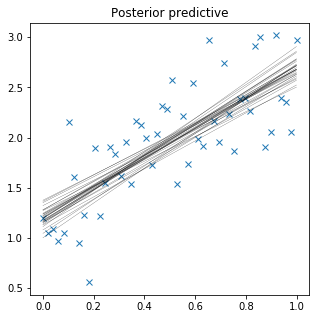

In [3]:
with Model() as model:
    lm = glm.LinearComponent.from_formula('y ~ x', data)
    sigma = Uniform('sigma', 0, 20)
    y_obs = Normal('y_obs', mu=lm.y_est, sd=sigma, observed=y)
    trace = sample(2000, cores=2)

plt.figure(figsize=(5, 5))
plt.plot(x, y, 'x')
plot_posterior_predictive_glm(trace)

Since there are a couple of general linear models that are being used over and over again (Normally distributed noise, logistic regression etc), the glm.glm() function simplifies the above step by creating the likelihood (y_obs) and its priors (sigma) for us. Since we are working in the model context, the random variables are all added to the model behind the scenes. This function also automatically finds a good starting point which it returns.

Note that the below call to glm() is producing exactly the same model as above, just more succinctly.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1439.14draws/s]


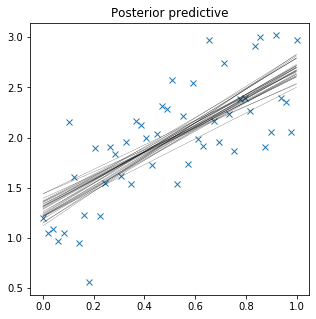

In [4]:
with Model() as model:
    GLM.from_formula('y ~ x', data)
    trace = sample(2000, cores=2)

plt.figure(figsize=(5, 5))
plt.plot(x, y, 'x')
plot_posterior_predictive_glm(trace)

# Robust GLM
Lets try the same model but with a few outliers in the data.

In [5]:
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])
data_outlier = dict(x=x_out, y=y_out)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1344.98draws/s]


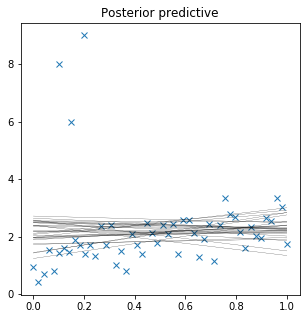

In [6]:
with Model() as model:
    GLM.from_formula('y ~ x', data_outlier)
    trace = sample(2000, cores=2)

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
plot_posterior_predictive_glm(trace)

Because the normal distribution does not have a lot of mass in the tails, an outlier will affect the fit strongly.

Instead, we can replace the Normal likelihood with a student T distribution which has heavier tails and is more robust towards outliers. While this could be done with the linear_compoment() function and manually defining the T likelihood we can use the glm() function for more automation. By default this function uses a normal likelihood. To define the usage of a T distribution instead we can pass a family object that contains information on how to link the output to y_est (in this case we explicitly use the Identity link function which is also the default) and what the priors for the T distribution are. Here we fix the degrees of freedom nu to 1.5.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, x, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1400.60draws/s]


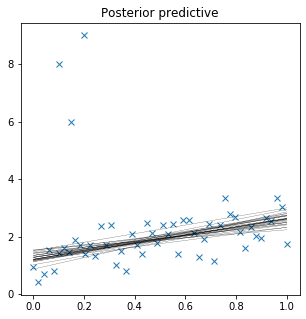

In [7]:
with Model() as model_robust:
    family = glm.families.StudentT(link=glm.families.Identity(),
                                   priors={'nu': 1.5,
                                           'lam': Uniform.dist(0, 20)})
    GLM.from_formula('y ~ x', data_outlier, family=family)
    trace = sample(2000, cores=2)

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, 'x')
plot_posterior_predictive_glm(trace)